# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

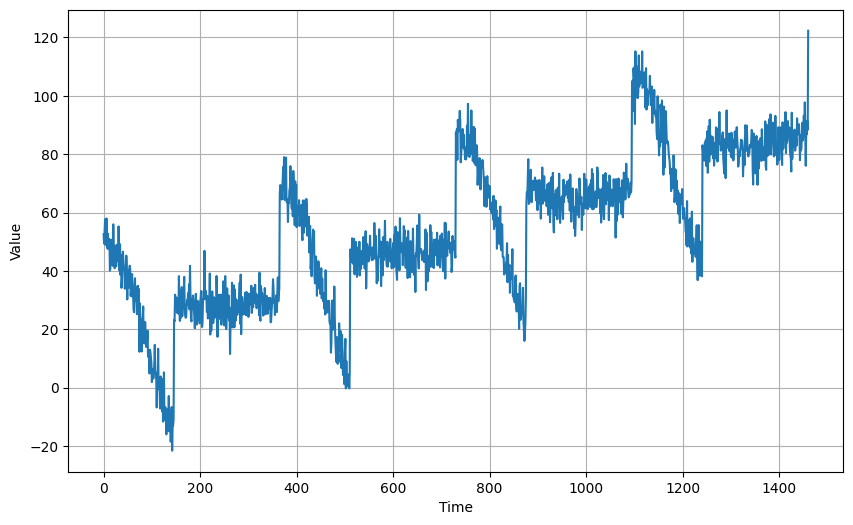

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [5]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

You will be using `SimpleRNN` layers later and as mentioned in its [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), these expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 data points in the window will be mapped to 20 timesteps of the RNN. To implement this, you will add an `expand_dims()` to the `windowed_dataset()` function you used in the previous labs. 

_Note: Technically, you will only need this extra line if you don't specify the input shape as you will do later when you build the model. Nonetheless, it is best practice to define transformations like this, especially in data pipelines. It can help make debugging easier in case you have problems later on._

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [8]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20, 1)
shape of label: (32, 1)


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should                    have `return_sequences` set to `True`. 

Normally, you can just have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use a `Lambda` layer to scale the output by 100 before it adjusts the layer weights. `Lambda` layers can be a useful tool to experiment with simple transformations like this. Feel free to remove this layer later after this lab and see what results you get.

In [10]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 20, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [11]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 134.5626 - learning_rate: 1.0000e-08
Epoch 2/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 132.9395

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 131.6348 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 127.9236 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 123.8793 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 119.5113 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 114.7771 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 109.5951 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 103.8615 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 97.5241 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 90.6764 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 83.6078 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step -

You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

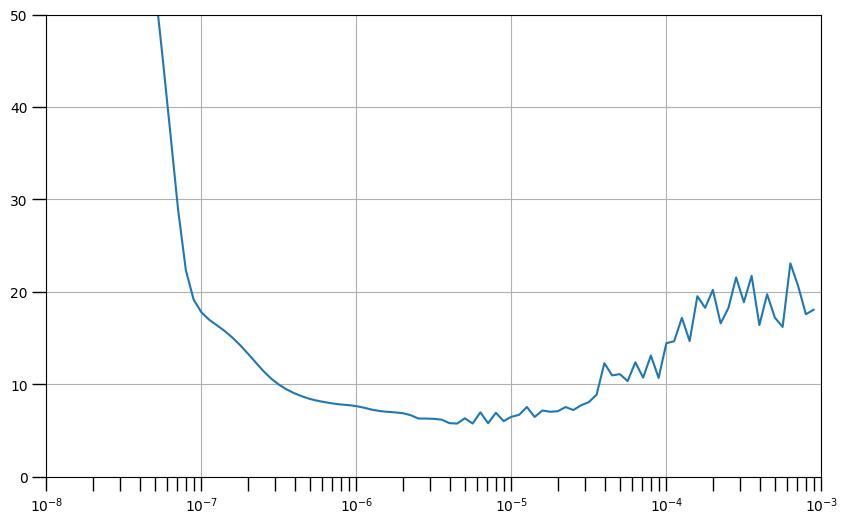

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

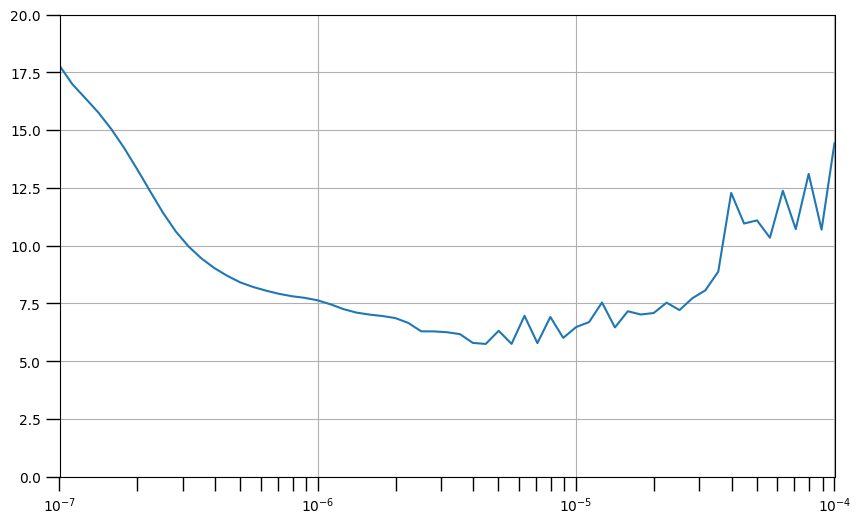

In [13]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [14]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 57.4636 - mae: 57.9613
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.5762 - mae: 13.0672
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1899 - mae: 8.6742
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9776 - mae: 7.4581
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5917 - mae: 7.0734
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3666 - mae: 6.8494
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2117 - mae: 6.6924
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1073 - mae: 6.5870
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0284 - mae: 6.5103
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9620 - mae: 6.4432
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9020 - mae: 6.3833
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8495 - mae: 6.3302
Epoch 13/100
31/31 ━━━━━━━━━━━━

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

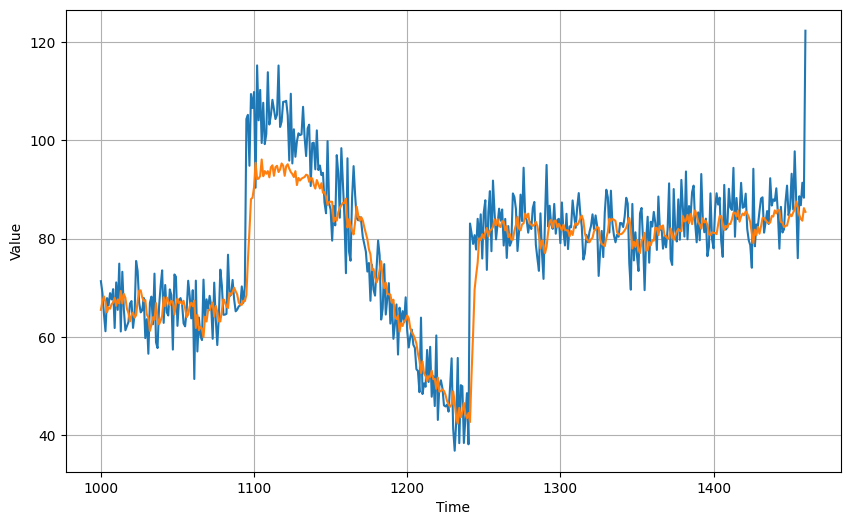

In [15]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

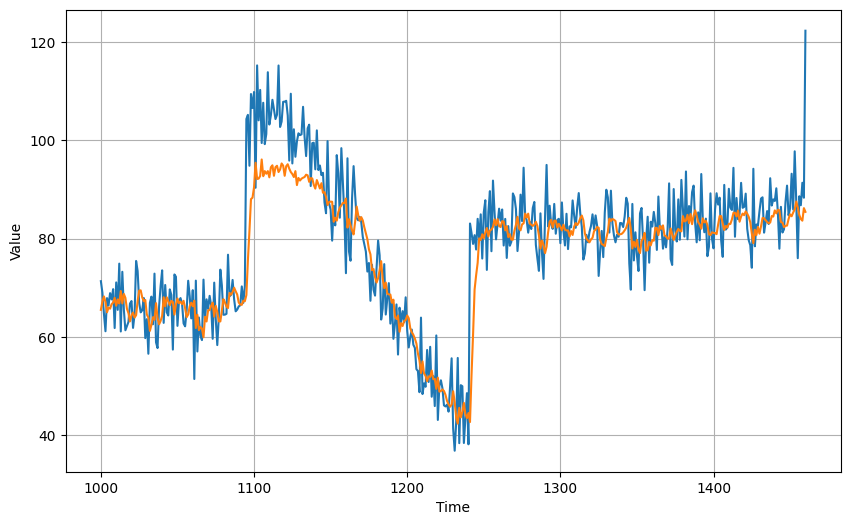

In [17]:
# Only needed in this lab. Reset the model but keep the trained weights to prepare for batched inputs.
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [18]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

54.909004
5.360865


## Wrap Up

In the next lab, you will explore a similar architecture but using LSTMs. Before doing so, run the cell below to free up resources. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press Ok. You can then close this lab, then go back to the classroom for the next lecture. See you there!

In [19]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}